In [2]:
import os
print("Current working directory:", os.getcwd())

Current working directory: /Users/ching-lung/deposit-prediction


## Import Packages

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta


## Import Dataset

In [6]:
# Load the .dta file into a DataFrame
df = pd.read_csv("/Users/ching-lung/deposit-prediction/cleaned_data/data_clean.csv")
df.head(5)


,Date,Real GDP growth,Nominal GDP growth,Real disposable income growth,Nominal disposable income growth,Unemployment rate,CPI inflation rate,3-month Treasury rate,5-year Treasury yield,10-year Treasury yield,...,Real GDP,Nominal disposable income,Real disposable income,Loans to individuals,Credit cards,Other loans to individuals,Deposits,Interest-bearing deposits,Noninterest-bearing deposits,Time deposits
0,1984Q1,8.1,12.5,7.9,12.7,7.9,5.8,9.2,11.7,11.9,...,4370.98,30668.53,3494.10,261504,46521,214984,2697459,1860467,363956,1242574
1,1984Q2,7.1,10.8,6.6,10.8,7.4,3.8,9.8,13.0,13.2,...,4681.32,33980.73,3724.71,277997,51159,226839,2773230,1921613,379300,1306506
2,1984Q3,3.9,7.7,5.3,8.6,7.4,3.5,10.3,12.8,12.9,...,4863.89,36903.07,3922.12,293062,56645,236417,2781986,1964713,364125,1370983
3,1984Q4,3.3,6.4,3.4,5.9,7.3,3.5,8.8,11.5,11.8,...,5024.40,39080.35,4055.47,311074,64110,246963,2907668,2043037,421536,1407295
4,1985Q1,3.9,8.1,-1.0,3.8,7.2,3.7,8.2,11.3,11.6,...,5220.35,40565.40,4014.92,319656,67028,252628,2916647,2086014,371462,1413727


In [8]:
df.columns

Index(['Date', 'Real GDP growth', 'Nominal GDP growth',
       'Real disposable income growth', 'Nominal disposable income growth',
       'Unemployment rate', 'CPI inflation rate', '3-month Treasury rate',
       '5-year Treasury yield', '10-year Treasury yield', 'Mortgage rate',
       'Prime rate', 'House Price Index (Level)',
       'Commercial Real Estate Price Index (Level)', 'Nominal GDP', 'Real GDP',
       'Nominal disposable income', 'Real disposable income',
       'Loans to individuals', 'Credit cards', 'Other loans to individuals',
       'Deposits', 'Interest-bearing deposits', 'Noninterest-bearing deposits',
       'Time deposits'],
      dtype='object')

## Exploratory Data Analysis

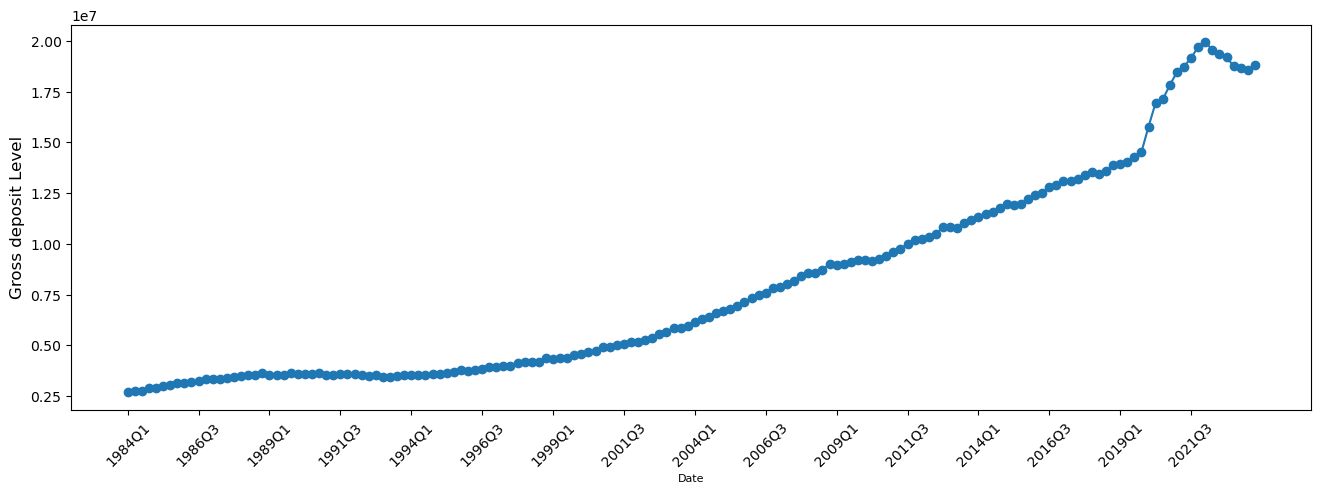

In [10]:
plt.figure(figsize=(16,5))
plt.plot(df.Date, df["Deposits"], '-o')
plt.xticks(df.Date[::10], rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Date", fontsize=8)
plt.ylabel("Gross deposit Level", fontsize=12)
plt.show()

## Feature Plots

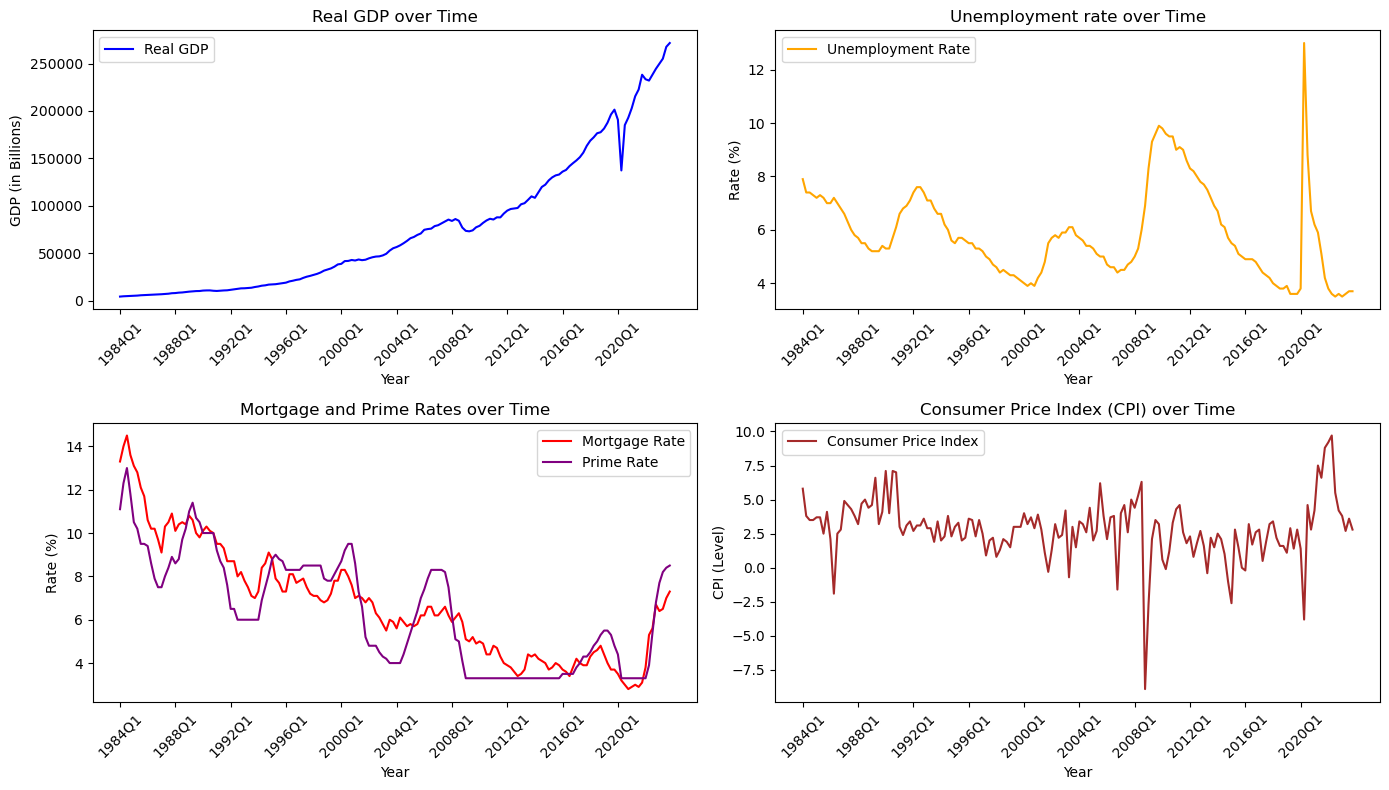

In [12]:
plt.figure(figsize=(14, 8))

# Subplot 1: Real and Nominal GDP
plt.subplot(2, 2, 1)
plt.plot(df.Date, df['Real GDP'], label='Real GDP', color='blue')
plt.title('Real GDP over Time')
plt.xlabel('Year')
plt.ylabel('GDP (in Billions)')
plt.xticks(ticks=df.index[::int(len(df)/10)], rotation=45)
plt.legend()

# Subplot 2: Real GDP Growth
plt.subplot(2, 2, 2)
plt.plot(df.Date, df['Unemployment rate'], label='Unemployment Rate', color='orange')
plt.title('Unemployment rate over Time')
plt.xlabel('Year')
plt.ylabel('Rate (%)')
plt.xticks(ticks=df.index[::int(len(df)/10)], rotation=45)
plt.legend()

# Subplot 3: Mortgage and Prime Rates
plt.subplot(2, 2, 3)
plt.plot(df.Date, df['Mortgage rate'], label='Mortgage Rate', color='red')
plt.plot(df.Date, df['Prime rate'], label='Prime Rate', color='purple')
plt.title('Mortgage and Prime Rates over Time')
plt.xlabel('Year')
plt.ylabel('Rate (%)')
plt.xticks(ticks=df.index[::int(len(df)/10)], rotation=45)
plt.legend()

# Subplot 4: Consumer Price Index (CPI)
plt.subplot(2, 2, 4)
plt.plot(df.Date, df['CPI inflation rate'], label='Consumer Price Index', color='brown')
plt.title('Consumer Price Index (CPI) over Time')
plt.xlabel('Year')
plt.ylabel('CPI (Level)')
plt.xticks(ticks=df.index[::int(len(df)/10)], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

## Correlation Heatmap

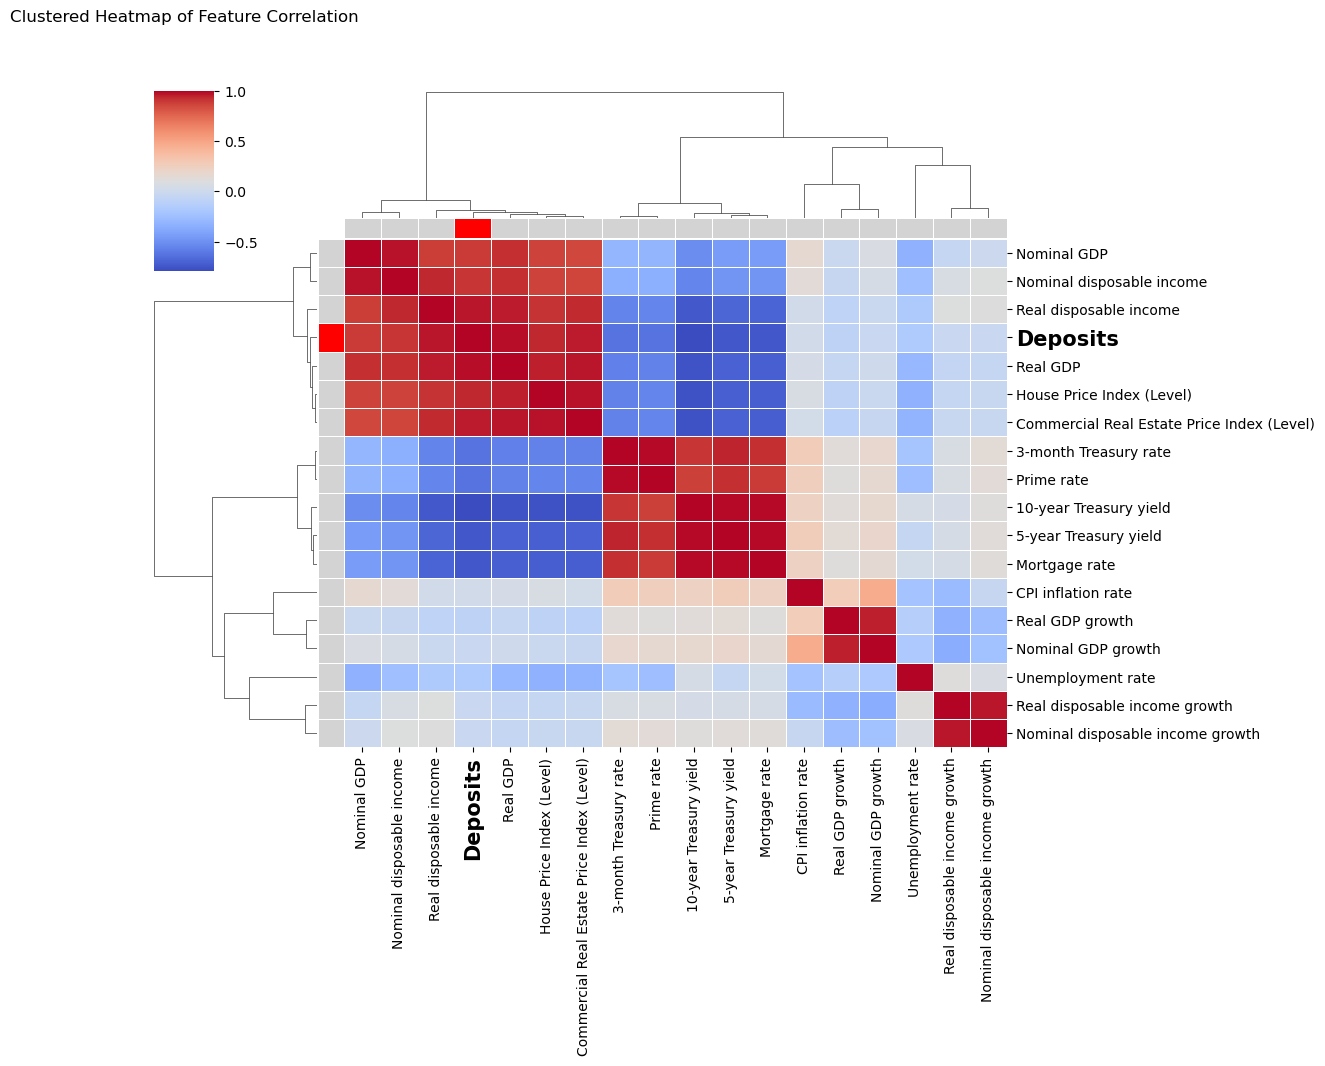

In [14]:
# Assuming 'df' is already defined
selected_columns = list(range(1, 18)) + [21]
correlation_matrix = df.iloc[:, selected_columns].corr()

# Create a mapping for label colors, highlight column 21
col_colors = ['lightgray'] * correlation_matrix.shape[0]
col_colors[-1] = 'red'  # Highlight the last column (column 21)

# Create the clustermap
clustermap = sns.clustermap(
    correlation_matrix,
    cmap='coolwarm',
    linewidths=0.5,
    figsize=(12, 10),
    col_colors=col_colors,  # Column colors
    row_colors=col_colors,  # Row colors
)

# Make the deposit column label bold
x_labels = clustermap.ax_heatmap.get_xticklabels()
y_labels = clustermap.ax_heatmap.get_yticklabels()

# Highlight the deposit label on both axes
x_labels[3].set_fontweight('bold')
y_labels[3].set_fontweight('bold')
x_labels[3].set_fontsize(15)  # Adjust font size
y_labels[3].set_fontsize(15)  # Adjust font size

# Apply changes back to the plot
clustermap.ax_heatmap.set_xticklabels(x_labels, rotation=90)
clustermap.ax_heatmap.set_yticklabels(y_labels)

# Add a title
plt.title('Clustered Heatmap of Feature Correlation', pad=50)
plt.show()

## Feature Selections

In [89]:
# Compute correlation matrix
correlation_matrix = predictors_train.corr()

# Identify pairs of highly correlated features (absolute correlation > threshold)
threshold = 0.85
correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            correlated_features.add(correlation_matrix.columns[i])

# Remove one feature from each pair
selected_features = predictors_train.columns.difference(correlated_features)
print("Selected Features:", selected_features)

# Use only selected features
predictors_train_reduced = predictors_train[selected_features]
predictors_test_reduced = predictors_test[selected_features]

Selected Features: Index(['3-month Treasury rate', 'CPI inflation rate',
       'House Price Index (Level)', 'Real GDP growth',
       'Real disposable income growth', 'Unemployment rate'],
      dtype='object')


## Stationary Analysis

### ADF Test

In [17]:
from statsmodels.tsa.stattools import adfuller, acf, pacf

# Function to apply ADF test and return results
def adf_test(series, column_name):
    result = adfuller(series.dropna())  # Dropping NA values to avoid errors
    output = {
        'Test Statistic': result[0],
        'p-value': result[1],
        'Lags Used': result[2],
        'Number of Observations': result[3],
        'Critical Values': result[4],
    }
    return pd.DataFrame(output, index=[column_name])

# Running ADF test on the deposits
adf_deposits = adf_test(df.Deposits, "Deposit")
adf_deposits

,Test Statistic,p-value,Lags Used,Number of Observations,Critical Values
Deposit,3.176465,1.0,14,145,NaN


### ACF and PACF

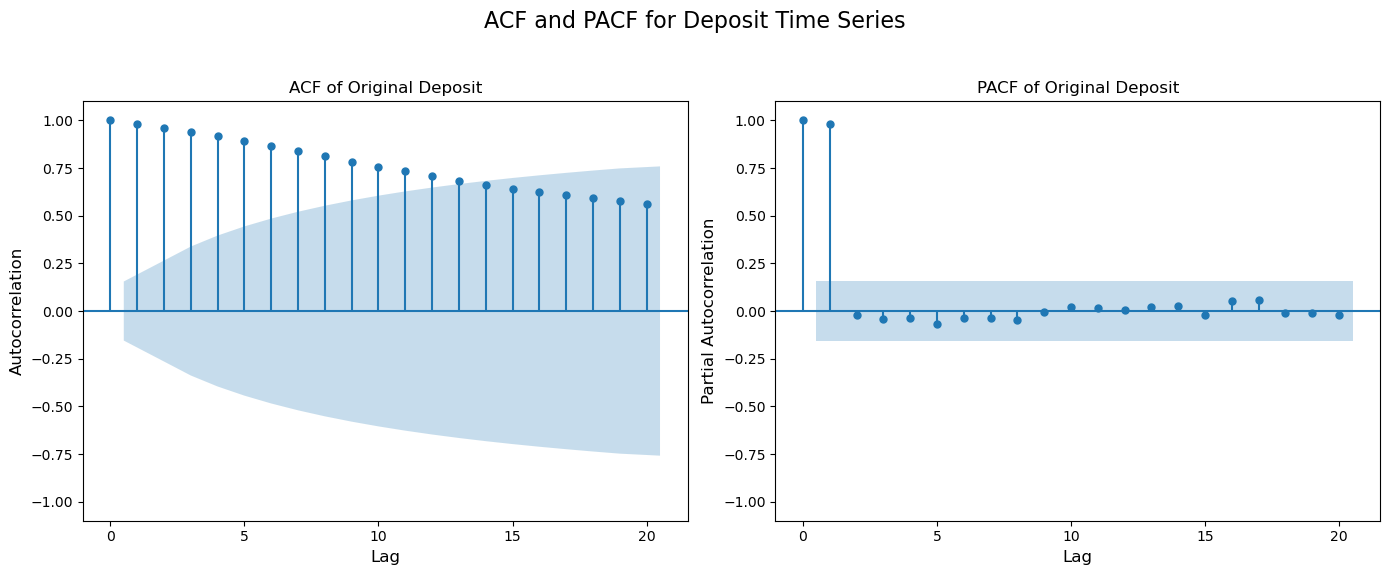

In [20]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt

# Compute ACF and PACF for the differenced series
lags = 20  # Number of lags to plot
acf_differenced = acf(df.Deposits, nlags=lags, fft=True)  # Use the differenced series
pacf_differenced = pacf(df.Deposits, nlags=lags)

# Plot the ACF and PACF for the differenced series
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("ACF and PACF for Deposit Time Series", fontsize=16)

# ACF plot using statsmodels
sm.graphics.tsa.plot_acf(df.Deposits, lags=lags, ax=axes[0], title="ACF of Original Deposit")
axes[0].set_ylabel("Autocorrelation", fontsize=12)
axes[0].set_xlabel("Lag", fontsize=12)
axes[0].set_ylim(-1.1, 1.1)

# PACF plot using statsmodels
sm.graphics.tsa.plot_pacf(df.Deposits, lags=lags, ax=axes[1], title="PACF of Original Deposit")
axes[1].set_ylabel("Partial Autocorrelation", fontsize=12)
axes[1].set_xlabel("Lag", fontsize=12)
axes[1].set_ylim(-1.1, 1.1)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Differencing

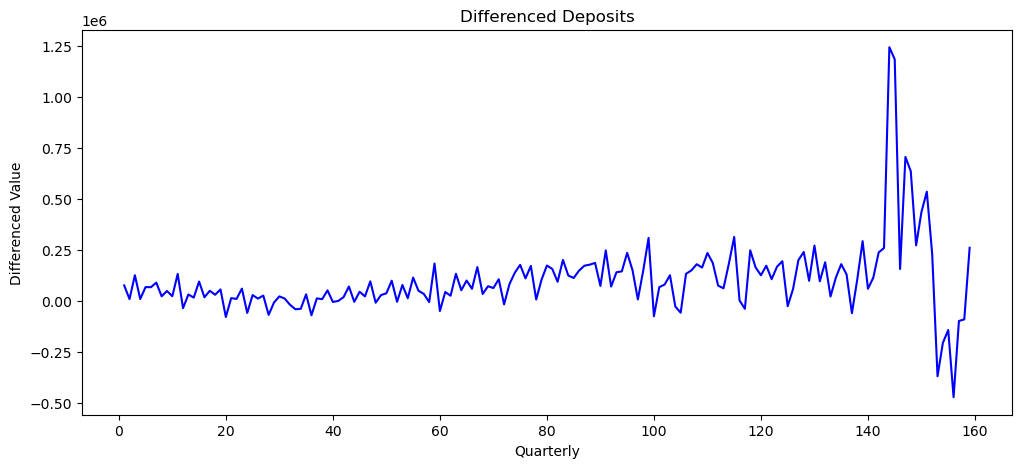

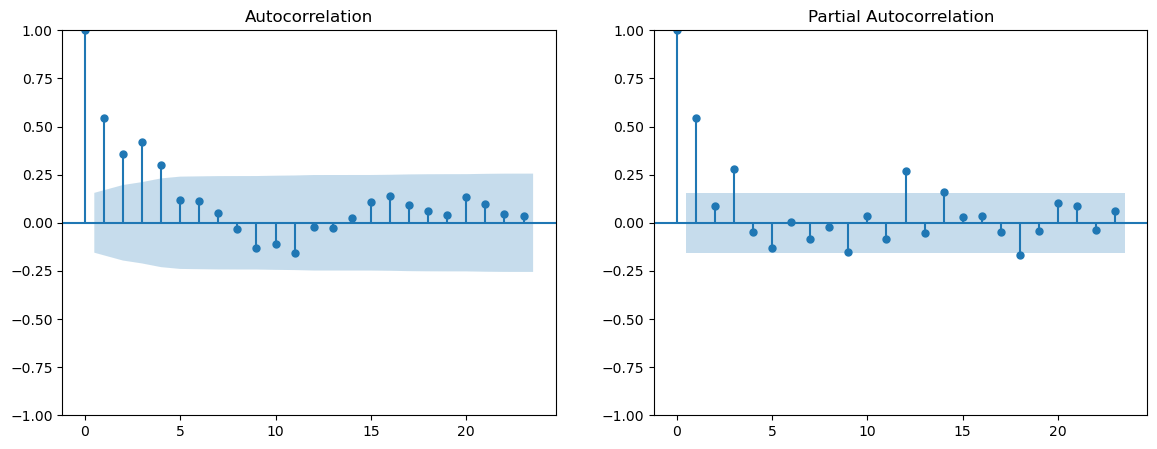

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Differencing the 'Non-maturity Interest-bearing deposits' series to make it stationary
dg = df.Deposits.copy().diff(1).dropna()

# Plot the differenced series to check for stationarity visually
plt.figure(figsize=(12, 5))
plt.plot(dg, color='blue')
plt.title('Differenced Deposits')
plt.xlabel('Quarterly')
plt.ylabel('Differenced Value')
plt.show()

# Step 2: Plot ACF and PACF to determine the order of ARIMA
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(dg, ax=ax[0])
plot_pacf(dg, ax=ax[1])

plt.show()

In [25]:
# Running ADF test on the deposits
adf_deposits_diff = adf_test(dg, "Deposit Difference")
adf_deposits_diff

,Test Statistic,p-value,Lags Used,Number of Observations,Critical Values
Deposit Difference,-0.654949,0.858076,14,144,NaN


Some comments about ARIMA, SARIMA, and SARIMAX...

In [28]:
df.shape

(160, 25)

## Train-Test Split

In [93]:
# Train-Test split for time series dataset

size = int(0.2*df.shape[0])
df_train = df.iloc[:-size].copy()
df_test = df.drop(df_train.index).copy()

dep_train = df['Deposits'].iloc[:-size].copy()
predictors_train = df[selected_features][:-size].copy()
date_train = df['Date'].iloc[:-size].copy()

dep_test = df.drop(dep_train.index).copy()
predictors_test = df[selected_features].drop(predictors_train.index).copy()
date_test = df.drop(date_train.index).copy()


## Feature Standardization

In [113]:
# Import necessary modules
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
predictors_train_scaled = scaler.fit_transform(predictors_train)

## ARIMA 

In [99]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# !pip install pmdarima
from pmdarima import auto_arima

In [101]:
sarima = auto_arima(y = dep_train.values, X = predictors_train_scaled, 
                    start_p = 0, d = 0, start_q = 0, 
                    max_p = 5, max_d = 5, max_q = 5, 
                    start_P = 0, D = 0, start_Q = 0, 
                    max_P = 2, max_D = 2, max_Q = 2, 
                    seasonal = True, m = 36, trace = True) 
sarima.summary()


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[36] intercept   : AIC=3947.825, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[36] intercept   : AIC=inf, Time=4.26 sec
 ARIMA(0,0,1)(0,0,1)[36] intercept   : AIC=3865.469, Time=1.48 sec
 ARIMA(0,0,0)(0,0,0)[36]             : AIC=4867.831, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[36] intercept   : AIC=3865.879, Time=0.03 sec
 ARIMA(0,0,1)(1,0,1)[36] intercept   : AIC=3867.428, Time=2.50 sec
 ARIMA(0,0,1)(0,0,2)[36] intercept   : AIC=3867.466, Time=3.73 sec
 ARIMA(0,0,1)(1,0,0)[36] intercept   : AIC=3867.839, Time=0.73 sec
 ARIMA(0,0,1)(1,0,2)[36] intercept   : AIC=3869.424, Time=5.57 sec
 ARIMA(0,0,0)(0,0,1)[36] intercept   : AIC=3936.942, Time=0.58 sec
 ARIMA(1,0,1)(0,0,1)[36] intercept   : AIC=3577.187, Time=1.10 sec
 ARIMA(1,0,1)(0,0,0)[36] intercept   : AIC=3575.778, Time=0.05 sec
 ARIMA(1,0,1)(1,0,0)[36] intercept   : AIC=3577.116, Time=1.01 sec
 ARIMA(1,0,1)(1,0,1)[36] intercept   : AIC=3579.006, Time=3.94 sec
 ARIMA(1,0,0)(0,0,0)[36]

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  128
Model:               SARIMAX(3, 0, 1)   Log Likelihood               -1772.193
Date:                Thu, 21 Nov 2024   AIC                           3568.386
Time:                        21:58:56   BIC                           3602.611
Sample:                             0   HQIC                          3582.292
                                - 128                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.548e+05    724.650    213.614      0.000    1.53e+05    1.56e+05
x1         -6.354e+05    668.445   -950.525      0.000   -6.37e+05   -6.34e+05
x2         -1.256e+05   1.12e+04    -11.211      0.000   -1.48e+05   -1.04e+05
x3          1.954e+06    195.743   9980.959      0.000    1.95e+06    1.95e+06
x4         -5.556e+04   2.28e+04     -2.432      0.015      -1e+05   -1.08e+04
x5          3.312e+04   1.58e+04      2.096      0.036    2146.717    6.41e+04
x6          6.838e+05   1082.697    631.602      0.000    6.82e+05    6.86e+05
ar.L1          1.6040      0.246      6.508      0.000       1.121       2.087
ar.L2         -0.4755      0.349     -1.363      0.173      -1.159       0.208
ar.L3         -0.1540      0.129     -1.193      0.233      -0.407       0.099
ma.L1         -0.5264      0.250     -2.106      0.035      -1.016      -0.037
sigma2      6.329e+10      0.011   5.96e+12      0.000    6.33e+10    6.33e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               190.24
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.75   Skew:                            -1.40
Prob(H) (two-sided):                  0.07   Kurtosis:                         8.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.06e+27. Standard errors may be unstable.
"""

In [115]:
# Define the SARIMAX model
model = SARIMAX(
    endog = dep_train.values,
    exog = scaler.transform(predictors_train),  # Pass None if no exogenous variables
    order = (3,0,1), # Example: (1, 1, 1)
    seasonal_order = (0,0,0,36),  # Example: (1, 1, 1, 12) for yearly seasonality
)

# Fit the model
sarima = model.fit(disp=False)
sarima.summary()


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  128
Model:               SARIMAX(3, 0, 1)   Log Likelihood               -1778.798
Date:                Thu, 21 Nov 2024   AIC                           3579.595
Time:                        22:01:36   BIC                           3610.967
Sample:                             0   HQIC                          3592.342
                                - 128                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -6.354e+05   1041.072   -610.307      0.000   -6.37e+05   -6.33e+05
x2         -1.256e+05   1.11e+04    -11.335      0.000   -1.47e+05   -1.04e+05
x3          1.954e+06    280.405   6967.449      0.000    1.95e+06    1.95e+06
x4         -5.556e+04   1.92e+04     -2.891      0.004   -9.32e+04   -1.79e+04
x5          3.312e+04   1.49e+04      2.217      0.027    3835.886    6.24e+04
x6          6.838e+05   1793.157    381.358      0.000     6.8e+05    6.87e+05
ar.L1          0.2732      0.261      1.046      0.296      -0.239       0.785
ar.L2          0.9259      0.238      3.890      0.000       0.459       1.392
ar.L3         -0.2005      0.100     -2.011      0.044      -0.396      -0.005
ma.L1          0.9051      0.250      3.620      0.000       0.415       1.395
sigma2      6.403e+10      0.014   4.55e+12      0.000     6.4e+10     6.4e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):               151.57
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               1.69   Skew:                            -1.30
Prob(H) (two-sided):                  0.09   Kurtosis:                         7.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.1e+28. Standard errors may be unstable.
"""

## Results

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


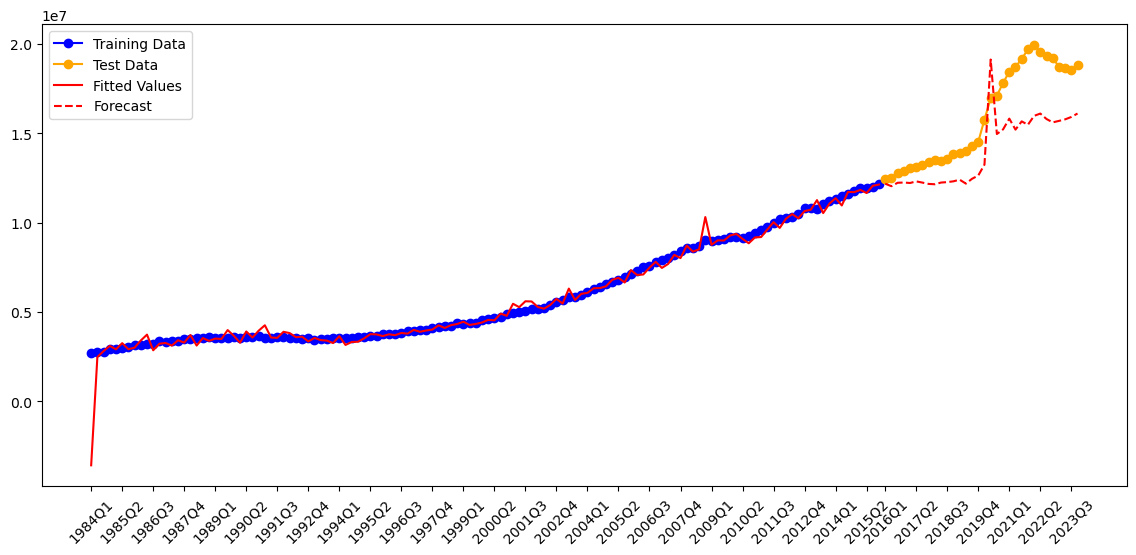

In [121]:
# Forecasting for the test period
forecast = sarima.get_forecast(steps=len(date_test), exog = scaler.transform(predictors_test.values)).predicted_mean

# Plot the results
plt.figure(figsize=(14, 6))

# Plot training data
plt.plot(date_train, dep_train, 'b-o', label='Training Data')

# Plot test data
plt.plot(date_test["Date"], dep_test.Deposits, color='orange', marker='o', label='Test Data')

# Plot fitted values for training data
plt.plot(date_train, sarima.fittedvalues, 'r', label='Fitted Values')

# Plot the forecast
plt.plot(date_test["Date"], forecast, '--r', label="Forecast")

# Add title with MASE if defined
if 'test_mase' in globals():
    plt.title("Test Set MASE = " + str(np.round(test_mase, 3)), fontsize=14)

# Customize x-axis ticks to display every 5th label with rotation
xticks = np.concatenate([date_train[::5], date_test["Date"][::5]])
plt.xticks(xticks, rotation=45, fontsize=10)

# Add legend
plt.legend()

# Show the plot
plt.show()


In [123]:
rolling_avg_train_preds = dep_train.rolling(12).mean()
rolling_avg_test_preds = rolling_avg_train_preds.iloc[-1] * np.ones(len(dep_test))


NameError: name 'mase' is not defined

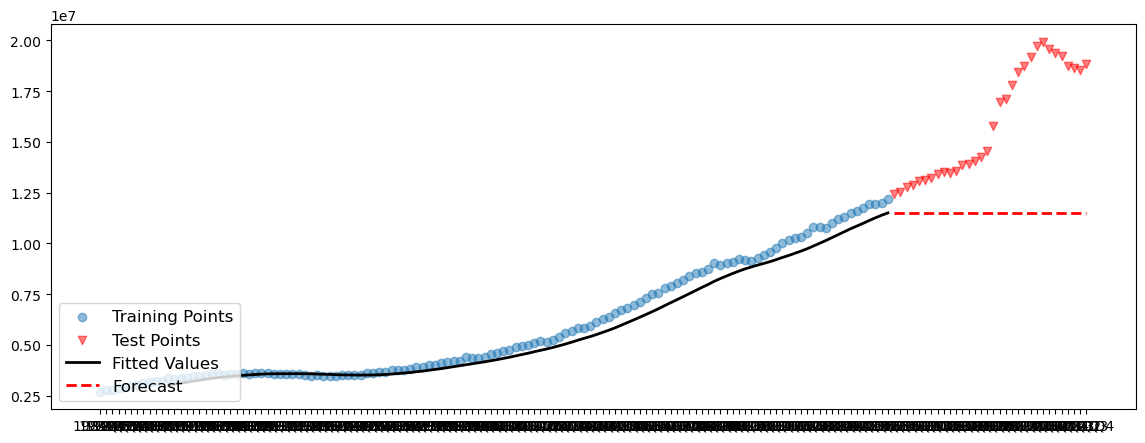

In [130]:
#baseline:
plt.figure(figsize=(14,5))
plt.scatter(df_train['Date'],
              dep_train,
               alpha=.5,
               label="Training Points")

plt.scatter(date_test.Date,
               dep_test.Deposits,
               alpha=.5,
               c = 'red',
               marker = 'v',
               label="Test Points")

plt.plot(df_train['Date'],
            rolling_avg_train_preds,
            'k-',
            linewidth = 2,
            label="Fitted Values")

plt.plot(date_test.Date,
            rolling_avg_test_preds,
            'r--',
            linewidth=2,
            label="Forecast")

plt.legend(fontsize=12, loc=3)

test_mase_base = mase(y_train = dep_train, y_test = dep_test.Deposits, y_preds = rolling_avg_test_preds)

plt.title("Test Set MASE = " + str(np.round(test_mase_base,3)),
             fontsize=14)

plt.xlabel("Deposit Level", fontsize=12)
plt.ylabel("Date", fontsize=12)






plt.show()

## Model Evaluation

In [14]:
def mase(y_train, y_test, y_preds):
    n = len(y_train)
    m = len(y_test)
    denom = 0
    for i in range(n-m):
        denom += np.abs(y_train[i+1:i+m+1] - y_train[i]*np.ones(m)).mean()
    denom = denom / (n-m)
    num = np.abs(y_test - y_preds).mean()
    return num/denom

In [ ]:
# MASE analysis:

test_mase = mase(y_train = dep_train.values, y_test = dep_test.deposits.values, y_preds = sarima.forecast(len(dep_test)))


In [ ]:
# MASE analysis:

test_mase = mase(y_train = dep_train.values, y_test = dep_test.deposits.values, y_preds = sarima.forecast(len(dep_test)))


In [ ]:
#k fold cross validation
#grid search for best seasonality
